In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

class RegressionNet(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(RegressionNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc3 = nn.Linear(hidden_size, output_size)

        def forward(self, x): 
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc3(out)
            return out

def neural_network_with_GMM_train(X,Y):
    input_size = 18
    hidden_size = 256
    output_size = 1

    GMM_model = RegressionNet(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(GMM_model.parameters(), lr=0.001)

    num_epochs = 1200
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        # 前向传播
        outputs = GMM_model(X)
        loss = criterion(outputs, Y) #+ 0.0001*data_loss(X,Y,outputs)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印训练过程中的损失
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_loss.append(loss.item())

        #predictions = model(test_x)
        #tt_loss = criterion(predictions,test_y)
        #test_loss.append(tt_loss.item())

    return GMM_model

def neural_network_predicting(model,test_x):
    # 在测试集上进行预测
    with torch.no_grad():
        predictions = model(test_x)

    predictions = predictions.numpy()
    return predictions

def GMM_filter(data):
    #best_aic,best_bic = compute_number_of_components(data,1,5)
    #n_components = best_aic  # 设置成分数量
    n_components = 2
    gmm = GaussianMixture(n_components=n_components)
    try:
        gmm.fit(data)
    except:
        #lenghts = len(data)
        gmm.fit(data.reshape((1000,2)))
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_
    return means,covariances,weights

def data_process_NN(train_set_file):
    with open(train_set_file, 'r') as train_file:
        lines = train_file.readlines()

    X = np.array([0]*18)
    for i in range(len(lines)):
        line = lines[i].strip().split(' ')
        line = [float(num) for num in line]     #200rtt + 200rssi
        line = np.array(line).reshape((2,1000))
        line[0] -= 20074.659
        #print(line)
        means,covariances,weights = GMM_filter(line.T)
        rtt_mean = np.mean(line[0])
        rtt_var = np.var(line[0])
        rssi_mean = np.mean(line[1])
        rssi_var = np.var(line[1])
        X = np.vstack((X,np.array([float(means[0][0]),float(means[0][1]),float(covariances[0][0][0]),float(covariances[0][0][1]),float(covariances[0][1][0]),float(covariances[0][1][1]),float(weights[0]),
                                   float(means[1][0]),float(means[1][1]),float(covariances[1][0][0]),float(covariances[1][0][1]),float(covariances[1][1][0]),float(covariances[1][1][1]),float(weights[1]),
                                   rssi_mean,rssi_var,rtt_mean,rtt_var])))
    X = X[1:,:]  #去掉第一行的0
    return X

def generate_train_test_y():
    distance_list = [i for i in range(1,12)]
    train_y = np.array([0])
    for distance in distance_list:
        for j in range(int(len(train_x)/len(distance_list))):
            train_y = np.vstack((train_y,distance))
    train_y = train_y[1:,:]

    test_y = np.array([0])
    for distance in distance_list:
        for j in range(int(len(test_x)/len(distance_list))):
            test_y = np.vstack((test_y,distance))
    test_y = test_y[1:,:]
    return train_y, test_y

def transform_error(error_array):
    error_list = []
    for i in range(11):
        error_list.append(error_array.reshape(220,)[i*20:(i+1)*20])
    error_array = np.array(error_list).T
    return error_array


#start of main()
train_x = data_process_NN('train_set/indoor_without_people_walking_train_set1000.txt')
test_x = data_process_NN('test_set/indoor_without_people_walking_test_set1000.txt')
#train_x = data_process_NN('train_set/indoor_without_people_walking_train_set.txt')
#test_x = data_process_NN('test_set/indoor_without_people_walking_test_set.txt')

train_y,test_y = generate_train_test_y()
print(train_x)
X = torch.from_numpy(train_x[:,:]).float()
Y = torch.from_numpy(train_y).float()
test_X = torch.from_numpy(test_x[:,:]).float()
test_Y = torch.from_numpy(test_y).float()

NN_with_GMM_model = neural_network_with_GMM_train(X,Y)
NN_with_GMM_predictions = neural_network_predicting(NN_with_GMM_model,test_X)

with_GMM_error = NN_with_GMM_predictions - test_y
with_GMM_error = transform_error(with_GMM_error)

def trimmed_data(error):
    trimmed_data = []
    for i in range(error.shape[1]):
        column_data = error[:, i]  # 取出每一组数据
        trimmed_column = np.clip(column_data, np.percentile(column_data, 10), np.percentile(column_data, 90))
        trimmed_data.append(trimmed_column)

    # 转换为numpy数组
    trimmed_data = np.column_stack(trimmed_data)
    return trimmed_data

with_GMM_error = trimmed_data(with_GMM_error)

c:\Users\11422\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\11422\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\11422\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\11422\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\11422\AppData\L

[[-8.08779657e-01 -3.39823789e+01  4.70959253e-01 ...  2.79360000e-02
   3.65000000e-01  1.35942400e+00]
 [-8.11204232e-01 -3.40000000e+01  4.33520241e-01 ...  0.00000000e+00
   3.23000000e-01  1.35967600e+00]
 [-7.55304252e-01 -3.40940363e+01  4.58660245e-01 ...  1.79536000e-01
   4.27000000e-01  1.28060400e+00]
 ...
 [ 2.49464379e+00 -4.80000000e+01  8.99092564e-01 ...  1.60000000e-02
   1.95500000e+00  7.67004000e-01]
 [ 3.59384117e-01 -4.70090485e+01  9.41278693e-01 ...  1.09510000e-02
   1.90300000e+00  8.84156000e-01]
 [ 2.34100000e+00 -4.81188976e+01  1.00000000e-06 ...  1.57616000e-01
   1.95900000e+00  7.06076000e-01]]
Epoch [1/1200], Loss: 1857873.3750
Epoch [2/1200], Loss: 2311199.5000
Epoch [3/1200], Loss: 1263891.5000
Epoch [4/1200], Loss: 18967.3477
Epoch [5/1200], Loss: 551562.5000
Epoch [6/1200], Loss: 1044213.1875
Epoch [7/1200], Loss: 559397.6875
Epoch [8/1200], Loss: 35444.9648
Epoch [9/1200], Loss: 144719.4531
Epoch [10/1200], Loss: 511783.0000
Epoch [11/1200], Loss

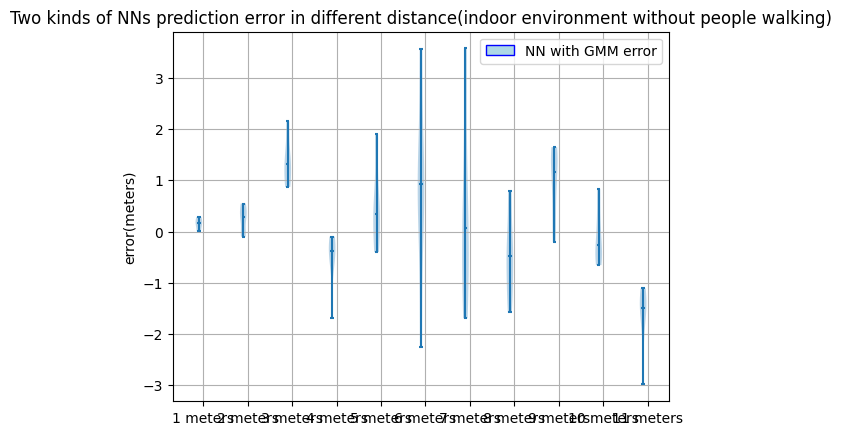

(20, 11)


In [2]:
boxprops = dict(facecolor='lightblue', color='blue')
plt.violinplot(with_GMM_error,positions=[i-0.2 for i in range(1,23,2)],showmedians=True,widths=0.3)
boxprops = dict(facecolor='red', color='maroon')

rect_ridge = plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', edgecolor='blue')
plt.legend([rect_ridge], ['NN with GMM error'])

labels = (['{} meters'.format(i) for i in range(1,12)])
plt.xticks([i for i in range(1,23,2)], labels)
plt.title('Two kinds of NNs prediction error in different distance(indoor environment without people walking)')
plt.ylabel('error(meters)')
plt.grid()
plt.show()

print(with_GMM_error.shape)


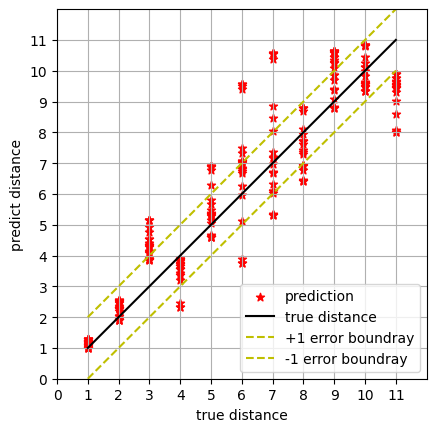

In [4]:
plt.figure()
ax = plt.subplot(111)
for i in range(0,11):
    if i == 1:
        ax.scatter([i+1]*20, with_GMM_error[:,i]+i+1, c = 'r', marker = '*', label = 'prediction')
    else:
        ax.scatter([i+1]*20, with_GMM_error[:,i]+i+1, c = 'r', marker = '*')

ax.plot([i for i in range(1,12)], [i for i in range(1,12)], c = 'black', label = 'true distance')
ax.plot([i for i in range(1,12)], [i+1 for i in range(1,12)], c = 'y', linestyle = '--', label = '+1 error boundray')
ax.plot([i for i in range(1,12)], [i-1 for i in range(1,12)], c = 'y', linestyle = '--', label = '-1 error boundray')
ax.set_aspect(1)
ax.grid(True)
ax.set_xlim((0,12))
my_x_ticks = np.arange(0, 12, 1)
ax.set_xticks(my_x_ticks)
ax.set_ylim((0,12))
my_y_ticks = np.arange(0, 12, 1)
ax.set_yticks(my_y_ticks)
ax.set_xlabel('true distance')
ax.set_ylabel('predict distance')
plt.legend()
plt.show()